[View in Colaboratory](https://colab.research.google.com/github/zhichengMLE/deep_learning/blob/master/COMS4995_HW1.ipynb)

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch, torchvision
import torch.optim as optim
from numpy import float32
import random

torch.__version__

'0.3.0.post4'

In [3]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Part 1

In [0]:
dataset_size = len(trainset)
train_ratio = 0.9
image_flatten_size = trainset[0][0].numpy().size
train_size = int(train_ratio * dataset_size)
valid_size = dataset_size - train_size
test_size = len(testset)


X_train = np.zeros((image_flatten_size, train_size), dtype=float32)
X_val = np.zeros((image_flatten_size, valid_size), dtype=float32)
X_test = np.zeros((image_flatten_size, test_size), dtype=float32)
y_train  = np.zeros((train_size), dtype=int)
y_val  = np.zeros((valid_size), dtype=int)
y_test  = np.zeros((test_size), dtype=int)

for i in range(train_size):
    X_train[:,i] = trainset[i][0].numpy().flatten()
    y_train[i] = trainset[i][1] 
for i in range(valid_size):
    X_val[:,i] = trainset[i+train_size][0].numpy().flatten()
    y_val[i] = trainset[i+train_size][1] 
for i in range(test_size):
    X_test[:,i] = testset[i][0].numpy().flatten()
    y_test[i] = trainset[i][1] 


In [0]:
class NeuralNetwork(object):
    def __init__(self, layer_dimensions):
        np.random.seed(100)
        self.nb_layers = len(layer_dimensions)
        
        self.parameters = {}
        self.parameters['W'] = {}
        self.parameters['b'] = {}
        self.parameters['Z'] = {}
        self.parameters['A'] = {}
        self.parameters['m'] = {}
        self.parameters['mb'] = {}
        self.parameters['s'] = {}
        self.parameters['sb'] = {}
        for i in range(self.nb_layers):
            self.parameters['W'][i] = np.random.randn(layer_dimensions[i], layer_dimensions[i - 1]) / np.sqrt(layer_dimensions[i - 1])
            self.parameters['b'][i] = np.zeros([layer_dimensions[i], 1])
            self.parameters['m'][i] = None
            self.parameters['mb'][i] = None
            self.parameters['s'][i] = None
            self.parameters['sb'][i] = None

    def affineForward(self, A, W, b):
        Z = np.dot(W, A) + b
        return Z
        
    def activationForward(self, A, activation="relu"):
        if activation == "relu":
            return self.relu(A)
        elif activation == "softmax":
            return self.softmax(A)
        else:
            raise NotImplemented
            
    def forwardPropagation(self, X):
        self.parameters["A"][0] = X
        for i in range(1, self.nb_layers-1):
            Z = self.affineForward(self.parameters["A"][i-1], self.parameters["W"][i], self.parameters["b"][i])
            A = self.activationForward(Z)
            self.parameters["Z"][i] = Z
            self.parameters["A"][i] = A
        
        # Softmax for last layer.
        Z = self.affineForward(self.parameters["A"][self.nb_layers-2], self.parameters["W"][self.nb_layers-1], self.parameters["b"][self.nb_layers-1])
        AL = self.activationForward(Z, "softmax")
        self.parameters["Z"][self.nb_layers-1] = Z
        self.parameters["A"][self.nb_layers-1] = AL
            
        return AL
    
    def costFunction(self, AL, y):
        cost = -np.sum(np.log(AL[y,range(y.shape[0])])) / y.shape[0]
        AL[y, range(y.shape[0])] -= 1
        dAL = AL / y.shape[0]
        return cost, dAL

    def affineBackward(self, dA_prev, cache, idx_layer=0):
        W, Z, A = cache
        mW, mb, s, sb = self.parameters['m'][idx_layer],self.parameters['mb'][idx_layer],self.parameters['s'][idx_layer],self.parameters['sb'][idx_layer]

        dA = self.activationBackward(np.dot(W.T, dA_prev), Z)
        dW = np.dot(dA_prev, A.T)
        db = np.expand_dims(np.sum(dA_prev, axis=1), axis=1)            
        
        return dA, dW, db

    def activationBackward(self, dA, cache):
        return dA * self.relu_derivative(cache)
    
    def backPropagation(self, dAL, Y, cache):
        dA_prev, dW, db = self.affineBackward(dAL, (self.parameters['W'][self.nb_layers-1], self.parameters['Z'][self.nb_layers-2], self.parameters['A'][self.nb_layers-2]), self.nb_layers-1)
        gradients = {}
        gradients[self.nb_layers-1] = {}
        gradients[self.nb_layers-1]['dW'] = dW
        gradients[self.nb_layers-1]['db'] = db
        
        for i in range(self.nb_layers-3, -1, -1):
            dA_prev,dW,db = self.affineBackward(dA_prev, (self.parameters['W'][i+1], self.parameters['Z'][i], self.parameters['A'][i]), i+1)
            gradients[i+1] = {}
            gradients[i+1]['dW'] = dW
            gradients[i+1]['db'] = db
            
        return gradients

    def updateParameters(self, gradients, alpha):
        for i in range(1, self.nb_layers):
            self.parameters['W'][i] = self.parameters['W'][i] - alpha * gradients[i]['dW']
            self.parameters['b'][i] = self.parameters['b'][i] - alpha * gradients[i]['db']

    def train(self, X_train, X_val, y_train, y_val, iters, alpha, batch_size):
        print_batch_freq = 30
        print_epoch_freq = 1
        alpha_decay_rate = 0.99
        min_alpha = 0.0001
        X_train_orig = X_train
        y_train_orig = y_train
        
        for i in range(0, iters):
            # shuffle all trainning data.
            index = np.random.randint(0, X_train_orig.shape[1], size=X_train_orig.shape[1])
            X_train = X_train_orig[:, index]
            y_train = y_train_orig[index]

            for j in range(math.ceil(X_train.shape[1] // batch_size)):
                # minibatch
                X_batch, y_batch = self.get_batch(X_train, y_train, j*batch_size, batch_size)
                # forward propogation
                AL = self.forwardPropagation(X_batch)
                # compute loss function
                cost, dAL = self.costFunction(AL, y_batch)
                # compute gradients of parameters
                self.parameters['Z'][0] = X_batch
                gradients = self.backPropagation(dAL, y_batch, None)
                # update parameters
                self.updateParameters(gradients, alpha)
                
                if(i % print_epoch_freq == 0 and (j + 1) % print_batch_freq == 0):
                    acc = np.sum(self.predict(X_batch) == y_batch) / y_batch.shape[0]
                    validation_acc = np.sum(self.predict(X_val) == y_val) / y_val.shape[0]
                    print("Iteration: %.5d/%.5d - Batch: [%.5d~%.5d]/%.5d - Cost: %.8f - Accuracy: %.8f - Validation Accuracy: %.8f - alpha: %.8f"%(i, iters, j*batch_size, (j+1)*batch_size, X_train.shape[1], cost, acc, validation_acc, alpha))
            if(alpha > min_alpha):
                alpha *= alpha_decay_rate

    def predict(self, X_new):
        A_prev = X_new
        for i in range(1, self.nb_layers):
            A = A_prev
            Z = self.affineForward(A, self.parameters["W"][i], self.parameters["b"][i])
            A_prev = self.activationForward(Z)
        y_pred = np.argmax(A_prev, axis=0)

        return y_pred

    def get_batch(self, X, y, idx, batch_size):
        index = np.random.randint(0,X.shape[1],size=batch_size)
        return X[:,index], y[index]
  
    def relu(self, X):
        return np.maximum(0, X)
    
    def softmax(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis = 0)  

    def relu_derivative(self, A):
        return np.where(A > 0, 1, 0)


In [6]:
layer_dimensions = [X_train.shape[0], 512, 256, 128, 64, 32, 10]
NN = NeuralNetwork(layer_dimensions)
NN.train(X_train, X_val, y_train, y_val, iters=100, alpha=0.05, batch_size=500)

Iteration: 00000/00100 - Batch: [14500~15000]/45000 - Cost: 2.24466163 - Accuracy: 0.18800000 - Validation Accuracy: 0.19600000 - alpha: 0.05000000
Iteration: 00000/00100 - Batch: [29500~30000]/45000 - Cost: 2.10547527 - Accuracy: 0.25600000 - Validation Accuracy: 0.26700000 - alpha: 0.05000000
Iteration: 00000/00100 - Batch: [44500~45000]/45000 - Cost: 1.99304939 - Accuracy: 0.31000000 - Validation Accuracy: 0.28360000 - alpha: 0.05000000
Iteration: 00001/00100 - Batch: [14500~15000]/45000 - Cost: 1.94042853 - Accuracy: 0.32000000 - Validation Accuracy: 0.32360000 - alpha: 0.04950000
Iteration: 00001/00100 - Batch: [29500~30000]/45000 - Cost: 1.77014902 - Accuracy: 0.37200000 - Validation Accuracy: 0.34460000 - alpha: 0.04950000
Iteration: 00001/00100 - Batch: [44500~45000]/45000 - Cost: 1.85142353 - Accuracy: 0.36000000 - Validation Accuracy: 0.35980000 - alpha: 0.04950000
Iteration: 00002/00100 - Batch: [14500~15000]/45000 - Cost: 1.64861314 - Accuracy: 0.44200000 - Validation Accur

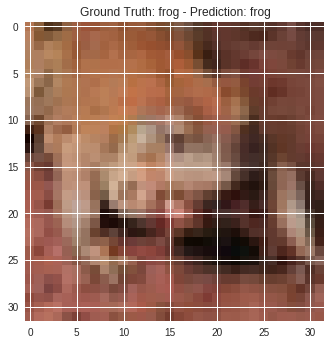

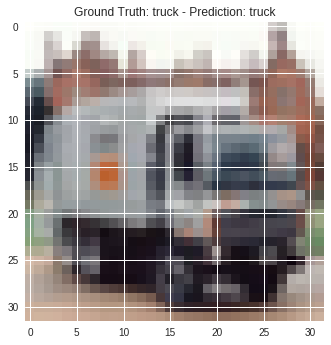

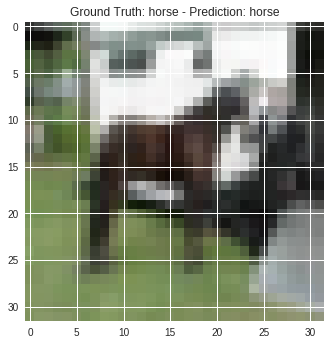

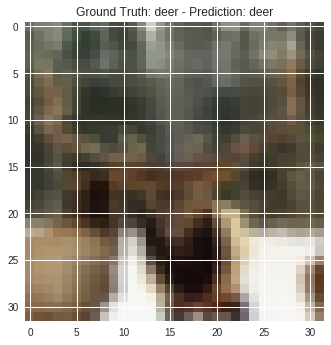

In [11]:
def imshow(img, title_info):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title_info)

result = (NN.predict(X_test))
test_list = [5, 11, 20, 26]
for i in test_list:
    imshow(testset[i][0], 'Ground Truth: %s - Prediction: %s' %(classes[testset[i][1]], classes[result[i]])) 

# Part 2